<a href="https://colab.research.google.com/github/jaguuai/Natural_Language_Processing.ipynb/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Data Analysis and Preparation

Natural language processing is teaching an AI system to understand and produce language, by asking it to find and copy patterns in human behavior. NLP is a huge part of artificial intelligence.

To build a natural language processing AI, we need to do four main things: 1) gather and clean the data, 2) set up the model, 3) train the model, and 4) make inferences.

First, we need to import our John Green transcripts from Vlogbrothers videos.

In [1]:
# STEP 1.1

from urllib.request import urlopen
txt = urlopen("https://raw.githubusercontent.com/crash-course-ai/lab2-nlp/master/vlogbrothers.txt").read().decode('ascii').split("\n")
print("Our dataset contains {} vlogbrothers scripts".format(len(txt)))
# ADVANCED_CHANGEME -- You can change this to load any text file
# You want it to be one line of plain text for every script.  Extra
# annotations like [John:] or *starts coughing* make learning more difficult.
everything = set([w for s in txt for w in s.split()])
print("and {} lexical types".format(len(everything)))

Our dataset contains 626 vlogbrothers scripts
and 31924 lexical types


Next, we need to do some preprocessing on our data to prepare it for our model. We're going to tokenize our text and split every sentence into a list of lexical tokens, including some rules for puctuation. And we're going to add markers for the start and end of each segment.

We also want to divide all our data into training and validation datasets, so our model can learn from the training data, but we can test it on the validation dataset that it has never seen before.


In [ ]:
# STEP 1.2

# 1. Import the tokenizer
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","tagger","ner","textcat"])

# 2. Tokenize
txt = [nlp(s) for s in txt]

# 3. Mark the beginning and end of each script
txt = [ ["<s>"] + [str(w) for w in s] + ["</s>"] for s in txt]

# 4. Separate the data into training and validation
train = txt[:-5]
valid = txt[-5:]

# 5. Flatten the lists into one long string and remove extra whitespace
train = [w for s in train for w in s if not w.isspace()]
valid = [w for s in valid for w in s if not w.isspace()]

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Great!  Now let's take a look at our data statistics -- specifically, how many lexical types and how many lexical tokens we have.

In [ ]:
# STEP 1.3

"""
    How big is our dataset?
"""
print("Our training dataset contains {} lexical types".format(len(set(train))))
print("Our training dataset contains {} lexical tokens".format(len(train)))

Our training dataset contains 22897 lexical types
Our training dataset contains 569698 lexical tokens


Let's take a closer look at the vocabulary and see what kinds of words human John Green likes to use more often than others. We’re going to figure out how many lexical types occur more than once, twice, and so on.


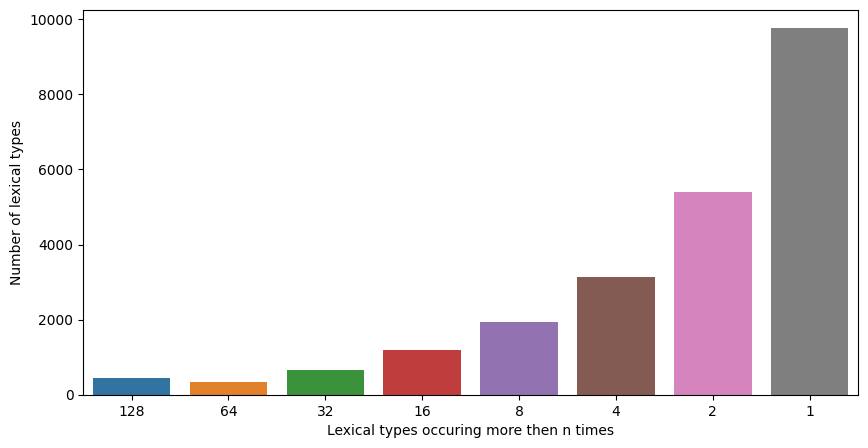

In [ ]:
# STEP 1.4

# 1. Count the frequencies of every word
from collections import Counter, defaultdict
counts = Counter(train)

frequencies = [0]*8
for w in counts:
  if counts[w] >= 128:
    frequencies[0] += 1
  elif counts[w] >= 64:
    frequencies[1] += 1
  elif counts[w] >= 32:
    frequencies[2] += 1
  elif counts[w] >= 16:
    frequencies[3] += 1
  elif counts[w] >= 8:
    frequencies[4] += 1
  elif counts[w] >= 4:
    frequencies[5] += 1
  elif counts[w] >= 2:
    frequencies[6] += 1
  else:
    frequencies[7] += 1


# 2. Plot their distributions
import matplotlib.pyplot as plt
import seaborn as sns

f,a = plt.subplots(1,1,figsize=(10,5))
a.set(xlabel='Lexical types occuring more then n times',
      ylabel='Number of lexical types')

labels = [128, 64, 32, 16, 8, 4, 2, 1]
_ = sns.barplot(x=labels, y=frequencies, ax=a, order=labels)

We have a lot of very rare words, words that only occur a single time in the dataset. These are very difficult to use when building a NLP model because our model will try to find and copy patterns, so it needs plenty of examples of how to use each word during training. Let's look at some of these rare words.


In [ ]:
# STEP 1.5

from textwrap import wrap
rare = [w for w in counts if counts[w] == 1]
for line in wrap("   ".join(["{:15s}".format(w) for w in rare[:100]]), width=70):
  print(line)

Pisgah            recycle           Inconvenient      sorta
ignored           Sheets            Toilet            Situation
oghomamamam       Oomph             Drinking          grizzly
malt              minty             alcoholy          tast-
achoo             Babysitter        Brave             Eden
Biblical          exalted           Eggers            Gourevitch
Thur-             patriarchal       Caravans          BP
58                Sixteen           condense          12:15
Misprinted        floss             terse             Punishment
Continuum         Apocalypticism    Emmitt            styrofoam
locations         Dances            Boxing            Federation
Upper             Poops             Poop              Kirsten
Dunst             Umbros            UEFA              Gunter
nonfictionaly     nonfictional      Roker             Ilyich
Linden            bullshit          Monty             Python
Idle              Lilliputians      Naked             gaping
theorem      

Some of these seem too difficult for our model to learn, like Liliputians. But the model could learn some of these if we helped simplify the words.

For example, what if we got rid of numbers by replacing them with #s? And what if we use our knowledge of word morphology to remove some endings like -ed or -ing?

In [ ]:
# STEP 1.6

# This is a little function to help us clean up the data
# CHANGEME -- Introduce or remove rules
import re
def simplify(w):
    # Remove extra punctuation
    w = w.replace("-", "").replace("~","")

    # Replace numbers with # sign
    w = re.sub('\d', '#', w)

    # Change some endings
    if len(w) > 3 and w[-2:] in set(["ed", "er","ly"]):
        return [w[:-2], w[-2:]]
    elif len(w) > 4 and w[-3:] in set(["ing","'re"]):
        return [w[:-3], w[-3:]]
    return [w]

19958 lexical types
612671 lexical tokens


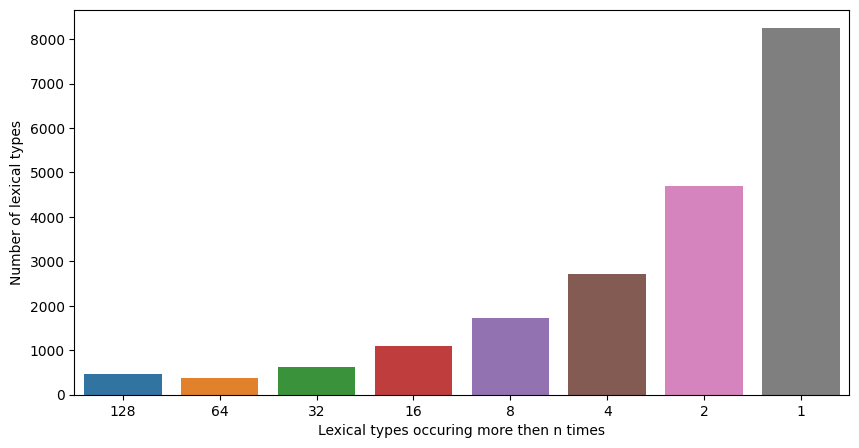

In [ ]:
# STEP 1.7

# 1. Go through and clean all of our data
train_clean = []
for w in train:
    for piece in simplify(w):
        train_clean.append(piece)
valid_clean = []
for w in valid:
    for piece in simplify(w):
        valid_clean.append(piece)

"""
    How big is our dataset?
"""
print("{} lexical types".format(len(set(train_clean))))
print("{} lexical tokens".format(len(train_clean)))

"""
    What's our distribution look like?
"""
counts = Counter(train_clean)


frequencies = [0]*8
for w in counts:
  if counts[w] >= 128:
    frequencies[0] += 1
  elif counts[w] >= 64:
    frequencies[1] += 1
  elif counts[w] >= 32:
    frequencies[2] += 1
  elif counts[w] >= 16:
    frequencies[3] += 1
  elif counts[w] >= 8:
    frequencies[4] += 1
  elif counts[w] >= 4:
    frequencies[5] += 1
  elif counts[w] >= 2:
    frequencies[6] += 1
  else:
    frequencies[7] += 1


# 2. Plot their distributions
f,a = plt.subplots(1,1,figsize=(10,5))
a.set(xlabel='Lexical types occuring more then n times',
      ylabel='Number of lexical types')

labels = [128, 64, 32, 16, 8, 4, 2, 1]
_ = sns.barplot(x=labels, y=frequencies, ax=a, order=labels)

This looks a lot better, because the bar of rare words that occur only once is smaller. There's probably more we can do, but let's keep moving forward.

There will /always/ be rare words, and the model needs to know how to handle these one way or another. So, we're going to replace rare lexical types with an `unk`, indicating they are unknown. This will let our model keep writing when it bumps into a one-time made-up word like "zombicorns."

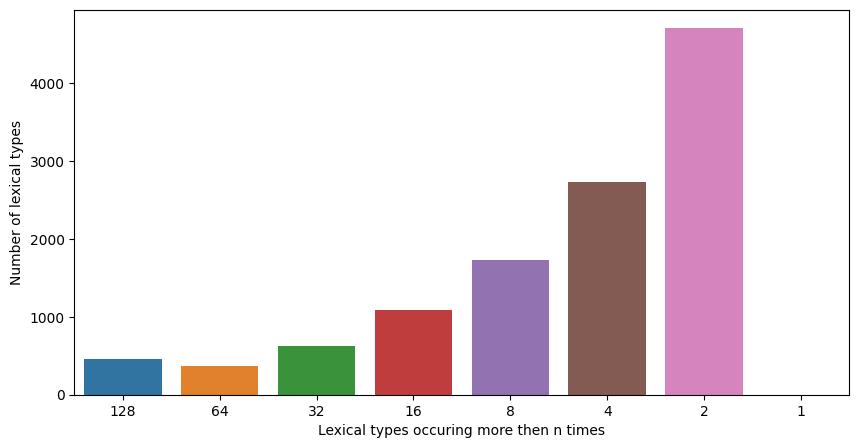

In [ ]:
# STEP 1.8

counts_clean = Counter(train_clean)
train_unk = [w if counts_clean[w] > 1 else "unk" for w in train_clean]
valid_unk = [w if w in counts_clean and counts_clean[w] > 1 \
               else "unk" for w in valid_clean]

# Let's plot these one last time
counts = Counter(train_unk)

frequencies = [0]*8
for w in counts:
  if counts[w] >= 128:
    frequencies[0] += 1
  elif counts[w] >= 64:
    frequencies[1] += 1
  elif counts[w] >= 32:
    frequencies[2] += 1
  elif counts[w] >= 16:
    frequencies[3] += 1
  elif counts[w] >= 8:
    frequencies[4] += 1
  elif counts[w] >= 4:
    frequencies[5] += 1
  elif counts[w] >= 2:
    frequencies[6] += 1
  else:
    frequencies[7] += 1


# 2. Plot their distributions
f,a = plt.subplots(1,1,figsize=(10,5))
a.set(xlabel='Lexical types occuring more then n times',
      ylabel='Number of lexical types')

labels = [128, 64, 32, 16, 8, 4, 2, 1]
_ = sns.barplot(x=labels, y=frequencies, ax=a, order=labels)

Great! Now we've really cut down on our rare words. Let's take a look at what we're losing.

In [ ]:
# STEP 1.9

rare = [w for w in counts_clean if counts_clean[w] == 1]
rare.sort()
for line in wrap("   ".join(["{:15s}".format(w) for w in rare[-100:]]), width=70):
  print(line)

wheels            wheezywait        whereabouts       whereby
whilst            whim              whimp             whimper
whines            whippersnappers   whiskeys          whistle
whittl            wholesale         whoo              whoosey
whopp             wi                widest            widows
wields            wifi              wigg              wil
wildebeests       wilderness        wildflowers
willallpreordersofthefaultinourstarsbesign
willallpreordersofturtlesallthewaydownbesign   willful
willingness       willpow           wimp              wina
windowless        winds             winkel            winter
wipe              wipes             wires             wis
witch             withdrew          witnesses         witty
woahWOAHWOAH      wobb              wobby             womb
woodblock         woodcuts          woodpeck          wooooo
wordless          workedOn          workings          worldliness
wormhole          worms             worsens           worthwhil

`woahWOAHWOAH`, `wowzy`, `zrbajarb` ... we'll be fine without those words for today. So now we have our data, we're done with preprocessing, and we're ready to build a model!

## Step 2: Model Definitions

There are a couple key things that we need to do to build a model. First, we need to convert the sentences into lists or arrays of numbers. We want one word for every lexical type, so we’ll build a dictionary that assigns every word in our vocabulary a number.

In [ ]:
# STEP 2.1

"""
  Prepare our datasets by converting words to numbers
"""
# Create a mapping from words <-> numbers
vocabulary = set(train_unk)
word_to_num = {}
num_to_word = {}
for num, word in enumerate(vocabulary):
  word_to_num[word] = num
  num_to_word[num] = word

# Convert our datasets into numbers
import torch
train = torch.LongTensor(len(train_unk))
for i in range(len(train_unk)):
  train[i] = word_to_num[train_unk[i]]

valid = torch.LongTensor(len(valid_unk))
for i in range(len(valid_unk)):
  valid[i] = word_to_num[valid_unk[i]]

Next, we need to convert our dataset into bite-sized pieces for the model.  Specifically, the `batch_size` is how many examples we look at during each step of training and the `seq_len` is how many words the model sees per example.  Here are some helpful functions that will do that for us.

In [ ]:
# STEP 2.2

# Parameters
batch_size = 20
seq_len = 35        # CHANGEME

# Tell Torch to use a GPU for computation
device = torch.device("cuda")
# Setting the random seed decreases variability
# Remove next three lines if running on your laptop
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# citation: https://github.com/pytorch/examples/tree/master/word_language_model
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

def get_batch(source, i, seq_len):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

train = batchify(train, batch_size)
valid = batchify(valid, batch_size)

Now, let's actually build our AI! We’ll need two key parts, an embedding matrix and a recurrent neural network or RNN.

An embedding matrix is a big list of vectors (which is basically a big table of numbers) where each row corresponds to a different word. These vector-rows capture how related two words are -- if two words are used in similar ways, then the numbers in their vectors should be similar. To start, every word will be assigned a vector with random numbers.

A RNN is basically a model that incrementally builds a hidden representation by incorporating one new word at a time. The RNN’s output after reading the final word in part of a sentence is what we’ll use to predict the next word, and this will be a key part of training the model in Step 3.




In [ ]:
# STEP 2.3

import torch.nn as nn

class EncoderDecoder(nn.Module):
  def __init__(self):
    """
        Define all the parameters of the model
    """
    super(EncoderDecoder, self).__init__()
    # How tightly should we compress our language represenations?
    self.embed_size = 300      # How big is our word vector   #ADVANCED_CHANGEME
    self.hidden_size = 600     # How big is our hidden space  #ADVANCED_CHANGEME

    """ Converting words to Vectors """
    # A lookup table for translating a word into a vector
    self.embedding = nn.Embedding(len(vocabulary), self.embed_size)
    # Initialize our word vectors with a random uniform distribution
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)


    """ An RNN (LSTM) with dropout """
    self.rnn = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size)
    self.shrink = nn.Linear(self.hidden_size, self.embed_size)
    self.drop = nn.Dropout(p=0.5)

    """ Predicting words from our model """
    # We convert our vector to a set of scores over words
    self.decode = nn.Linear(self.embed_size, self.embedding.weight.size(0))
    # We use the same matrix for this ``decoding'' that we used for ``encoding''
    # https://arxiv.org/abs/1608.05859
    self.decode.weight = self.embedding.weight
    self.decode.bias.data.zero_()


  def forward(self, input, hidden=None):
    """
        Run the model
    """
    # 1. Map words to vectors
    embedded = self.embedding(input)
    # 2. Process with an RNN
    if hidden is not None:
      output, hidden = self.rnn(embedded, hidden)
    else:
      output, hidden = self.rnn(embedded)
    # 3. Apply dropout
    output = F.relu(self.shrink(self.drop(output)))
    # 4. Score the likelihood of every possible next word
    decoded = self.decode(output)
    return hidden, decoded

## Step 3: Model Training

Now it's time to iterate over our dataset (specifically, those pieces called batches) and run backpropagation on each example to train the model’s weights. Over the span of one epoch of training this model, the network will loop over every batch of data -- reading it in, building representations, predicting the next word, and then updating its guesses.

To start, we're going to train our model over 10 epochs, so this might take a couple minutes to run.

We’ll print two numbers with each epoch, which are the model’s training and validation perplexities. As the model learns, it realizes there are fewer and fewer good choices for the next word. The perplexity is a measure of how well the model has narrowed down the choices. We can interpret perplexity as the average number of guesses the model makes before it predicts the right answer.

In [ ]:
# STEP 3.1

import torch.nn.functional as F
def training(model, data, targets, hidden):
  # Reset the model
  model.zero_grad()

  # Run the model to see its predictions and hidden states
  hidden, prediction_vector = model(data, hidden)
  prediction_vector = prediction_vector.view(len(targets), -1)
  # Compare the model's predictions at each timestep to the original data
  loss = F.cross_entropy(prediction_vector, targets)

  # Compute gradients and perform back-propagation
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)

  # Return the current model loss on this data item
  return loss.item(), repackage_hidden(hidden)

In [ ]:
# STEP 3.2

def evaluation(model):
  """
    This function performs almost all the same logic as the training function
    but it does not perform backpropagation, because we don't want to learn
    from this data, just check our performance.
  """
  model.eval()
  hidden = None
  valid_loss = 0
  for i in range(0, valid.size(0) - seq_len, seq_len):
    data, targets = get_batch(valid, i, seq_len)
    hidden, prediction_vector = model(data, hidden)
    hidden = repackage_hidden(hidden)

    prediction_vector = prediction_vector.view(-1, len(vocabulary))
    loss = F.cross_entropy(prediction_vector, targets)
    valid_loss += loss.item()
  return valid_loss / (valid.size(0)/seq_len)

In [ ]:
# STEP 3.3

# Create an instance of the model
import numpy as np
import time
import torch.optim as optim

model = EncoderDecoder().float().to(device)


# This value should match the batch_size used earlier for splitting up the data
batch_size = 20

# How long should we train?
num_epochs = 10                # CHANGEME

# How do we know when to stop training?
prev_valid_loss = 1e100
overfitting = False

timing = time.time()
for epoch in range(num_epochs):

  # Set the model to training mode and iterate through the dataset
  model.train()
  optimizer = optim.Adam(model.parameters())
  hidden = None
  train_loss = 0
  start_time = time.time()
  for i in range(0, train.size(0) - 1, seq_len):
    # Get the next training batch
    data, targets = get_batch(train, i, seq_len)

    # Run the model and perform backpropagation
    loss, hidden = training(model, data, targets, hidden)
    train_loss += loss
    optimizer.step()

  # Evaluate how well the model predicts unseen validation data
  valid_loss = evaluation(model)

  # Print the training and validation performance
  train_loss /= (train.size(0)/seq_len)
  finish_time = time.time()
  print("Epoch {:2} took {:3.2f}s with train perplexity: {:7.2f}"\
        " and validation: {:7.2f}".format(epoch, finish_time - start_time,
                                          np.exp(train_loss),
                                          np.exp(valid_loss)))

  # Check if the model's ability to generalize has gotten worse.
  # If so, slow the learning rate (shrink the step size)
  if valid_loss > prev_valid_loss:
    if not overfitting:
      print("Uhoh, looks like we are overfitting, maybe we need fewer epochs")
    else:
      print("I think it's time to stop")
      break
    overfitting = True
  prev_valid_loss = valid_loss

total_time = (time.time() - timing)/60
print("Completed {} epochs in {:5.3f} minutes".format(epoch, total_time))


Epoch  0 took 12.93s with train perplexity:  231.62 and validation:  106.52
Epoch  1 took 11.94s with train perplexity:  118.85 and validation:   92.05
Epoch  2 took 12.09s with train perplexity:   99.97 and validation:   87.29
Epoch  3 took 13.91s with train perplexity:   90.70 and validation:   85.83
Epoch  4 took 12.46s with train perplexity:   84.54 and validation:   86.59
Uhoh, looks like we are overfitting, maybe we need fewer epochs
Epoch  5 took 12.61s with train perplexity:   80.10 and validation:   86.23
Epoch  6 took 12.64s with train perplexity:   76.35 and validation:   87.50
I think it's time to stop
Completed 6 epochs in 1.476 minutes


## Step 4: Inference

So far in Crash Course AI, we've looked at models that produce a "best label" or "best prediction," but  here, there is no "right" answer. We're just building a generative model -- a model that can generate outputs.

If we wrote stories by always having characters do the most obvious next thing, they’d be pretty boring. So we’re going to implement a basic sampler in our program, whicih will take a bunch of random paths instead of just choosing the highest-scoring next word every time.

We can sort the results by the probability of the full sentences, and we can see which sentences are best overall.

To start this generation, we need to give our model a word to begin every sentence. Let’s try “Good” for now, but you can try other things by changing the code.

In [ ]:
# STEP 4.1

# What do we want the model to start the sentence with?
prefix = "<s> Good"      #CHANGEME

# How many words do we want the model to produce?
words_to_generate = 50   #CHANGEME

# We are only going to be looking at one example at a time
batch_size = 1

# Set the model to be in evaluation mode (no backprop!)
model.eval()

# Let's get lots of possible sentences
argmax_sent = None
argmax_prob = 0
collection = []
for item in range(100):
  # Convert our sentence start into numbers
  test = [word_to_num[word] if word in word_to_num else word_to_num["unk"] \
          for word in prefix.split()]
  probabilities = []

  # Run the model on the same initial input and it's own generations until
  # we reach `word_to_generate`
  for w in range(words_to_generate):
    # Run the model
    input = torch.from_numpy(np.array(test)).to(device)
    _, output = model(input.view(-1,1))

    # Get the prediction for the last (next) word
    last_pred = output[-1,:,:].squeeze()

    # We're going to block generation of unk
    last_pred[word_to_num["unk"]] = -100

    # Do we want to sample from this distrubtion?
    if item > 0:
      # A temperature makes the distribution peakier (if < 1) or flatter if > 1
      last_pred /= 0.70   #ADVANCED_CHANGEME

      # Turn this into a distribution
      dist = torch.distributions.categorical.Categorical(logits=last_pred)

      # Sample
      predicted_idx = dist.sample().item()

    else:
      # If we aren't sampling, just take the most probable word
      _, predicted_idx = last_pred.max(0)
      predicted_idx = predicted_idx.item()

    # Save the predicted word's probability
    value = F.log_softmax(last_pred,-1)[predicted_idx].item()

    # Add this predicted word (index) to the list
    test.append(predicted_idx)
    # Save the probability for sorting later
    probabilities.append(value)

  if item > 0:
    # Add our sentence and its score to a list
    generation = (np.exp(np.sum(probabilities)), \
                       " ".join([num_to_word[w] for w in test]))
    if generation not in collection:
      collection.append(generation)
  else:
    argmax_sent = " ".join([num_to_word[w] for w in test])
    argmax_prob = np.exp(np.sum(probabilities))

# Get the best model predictions
collection.sort()
collection.reverse()
print("Argmax Generation:")
print("{:.2E}:  {}\n".format(argmax_prob,"\n\t\t".join(wrap(argmax_sent))))
print("\nSampled Generations:")
for probability, sent in collection[:10]:
  print("{:.2E}:  {}\n".format(probability, "\n\t\t".join(wrap(sent))))

Argmax Generation:
9.29E-43:  <s> Good morn ing Hank , it 's Tuesday . So I 'm go ing to be a little
		bit of a lot of people who are like , " I 'm not a little bit of the
		book , but I 'm not a little bit of the book . "


Sampled Generations:
1.02E-12:  <s> Good morn ing Hank , it 's Tuesday . It 's question Tuesday . I 'm
		go ing to read it ! Hank , I 'll see you on Friday . </s> <s> Good
		morn ing Hank , it 's Tuesday . It 's question Tuesday , the day that
		I

9.04E-19:  <s> Good morn ing Hank , it 's Thursday . </s> <s> Good morn ing Hank
		, it 's Thursday . Today , I 'm not gon na talk about it . Hank , I
		'll see you tomorrow . </s> <s> Good morn ing , Hank , it 's Tuesday .

2.02E-21:  <s> Good morn ing Hank , it 's Wednesday . Hank , DFTBA , I 'll see
		you on Friday . </s> <s> birthday , Hank , it 's Tuesday , Ju ly ##th
		. </s> <s> Good morn ing Hank , it 's Sunday . I 've been think ing
		about

5.58E-23:  <s> Good morn ing , Hank , it 's Tuesday . It 's Question Tu

The sentence we get from taking the highest probability word each time (the Argmax) isn’t as interesting as the ones where we mixed it up a bit and took different branches (the other Sampled Generations).

Building models that interact with people, and the world, is why natural language processing is so exciting, but it’ll take a lot more work to get our model to generate language as well as human John Green does.

We’ve left a bunch of notes in the code for you to play with when making your own AI! You could train for longer, change the sentence prompt, or, if you’re feeling adventurous, replace the text data to speak in someone else’s voice. All you need is transcripts of their videos to get started.
